<a href="https://colab.research.google.com/github/adapachaitanya93/AI-Business-Analytics-Portfolio/blob/main/week1_lead_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#predict whether a client will subscribe to a term deposit
!pip install -q scikit-learn pandas numpy shap joblib
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score
import joblib


In [26]:
import pandas as pd
url = 'https://raw.githubusercontent.com/adapachaitanya93/AI-Business-Analytics-Portfolio/main/Week1_LeadScoring/bank-full.csv'
df = pd.read_csv(url, sep=';')  # sometimes uses ‘;’ as separator
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [77]:
"""
📘 Business Context

This dataset represents the results of a Portuguese banking institution’s marketing campaigns.
The goal was to predict whether a client would subscribe to a term deposit (a fixed-term savings account with guaranteed interest).
This project reframes it as a lead scoring model, helping sales and marketing teams prioritize high-conversion clients."""


'\n📘 Business Context\n\nThis dataset represents the results of a Portuguese banking institution’s marketing campaigns.\nThe goal was to predict whether a client would subscribe to a term deposit (a fixed-term savings account with guaranteed interest).\nThis project reframes it as a lead scoring model, helping sales and marketing teams prioritize high-conversion clients.'

In [78]:
# Dataset Understanding
"""
| Column        | Type            | Description                                                           | Business Meaning                                                        |
| ------------- | --------------- | --------------------------------------------------------------------- | ----------------------------------------------------------------------- |
| **age**       | Numeric         | Age of the client                                                     | Older clients are usually more financially stable and likely to invest. |
| **job**       | Categorical     | Type of job (admin, technician, services, student, retired, etc.)     | Indicates socioeconomic segment.                                        |
| **marital**   | Categorical     | Marital status (married, single, divorced)                            | Can affect financial priorities.                                        |
| **education** | Categorical     | Education level (primary, secondary, tertiary, unknown)               | Correlates with income and financial literacy.                          |
| **default**   | Categorical     | Has credit in default? (yes/no)                                       | Default history may reduce investment likelihood.                       |
| **balance**   | Numeric         | Average yearly bank balance (in euros)                                | Proxy for financial capacity to invest.                                 |
| **housing**   | Categorical     | Has housing loan? (yes/no)                                            | Clients with loans may have lower savings ability.                      |
| **loan**      | Categorical     | Has personal loan? (yes/no)                                           | Debt burden affects investment appetite.                                |
| **contact**   | Categorical     | Communication type (cellular / telephone)                             | Certain channels convert better — cellular often higher.                |
| **day**       | Numeric         | Last contact day of the month                                         | Operational field — minimal predictive power.                           |
| **month**     | Categorical     | Month of last contact                                                 | Captures seasonal campaign effects.                                     |
| **duration**  | Numeric         | Call duration (in seconds)                                            | **Strongest predictor** — longer calls mean higher engagement.          |
| **campaign**  | Numeric         | Number of contacts during this campaign                               | Persistence metric; high values may indicate saturation.                |
| **pdays**     | Numeric         | Days since last contact in a previous campaign (-1 = never contacted) | Measures recent re-engagement.                                          |
| **previous**  | Numeric         | Number of contacts before this campaign                               | Reflects historical marketing effort.                                   |
| **poutcome**  | Categorical     | Outcome of previous campaign (success/failure/unknown)                | Past success predicts current conversion.                               |
| **y**         | Target (yes/no) | Client subscribed to a term deposit?                                  | The classification target (1 = Yes, 0 = No).                            |
"""


'\n| Column        | Type            | Description                                                           | Business Meaning                                                        |\n| ------------- | --------------- | --------------------------------------------------------------------- | ----------------------------------------------------------------------- |\n| **age**       | Numeric         | Age of the client                                                     | Older clients are usually more financially stable and likely to invest. |\n| **job**       | Categorical     | Type of job (admin, technician, services, student, retired, etc.)     | Indicates socioeconomic segment.                                        |\n| **marital**   | Categorical     | Marital status (married, single, divorced)                            | Can affect financial priorities.                                        |\n| **education** | Categorical     | Education level (primary, secondary, tertiary,

In [32]:
df.columns
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [34]:
df['converted'] = (df['y'] == 'yes').astype(int)

In [35]:
df['converted'].value_counts()

,count
converted,
0,39922
1,5289


In [36]:
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,converted
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0


from matplotlib import pyplot as plt
_df_0['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['balance'].plot(kind='hist', bins=20, title='balance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['duration'].plot(kind='hist', bins=20, title='duration')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('job').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('marital').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('education').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('housing').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='age', y='balance', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='balance', y='duration', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['day']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('day', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('job')):
  _plot_series(series, series_name, i)
  fig.legend(title='job', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('day')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['day']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('day', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('marital')):
  _plot_series(series, series_name, i)
  fig.legend(title='marital', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('day')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['day']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('day', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('education')):
  _plot_series(series, series_name, i)
  fig.legend(title='education', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('day')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['day']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('day', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('housing')):
  _plot_series(series, series_name, i)
  fig.legend(title='housing', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('day')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
_df_13['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['balance'].plot(kind='line', figsize=(8, 4), title='balance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['duration'].plot(kind='line', figsize=(8, 4), title='duration')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['marital'].value_counts()
    for x_label, grp in _df_16.groupby('job')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('job')
_ = plt.ylabel('marital')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in _df_17.groupby('marital')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('marital')
_ = plt.ylabel('education')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['housing'].value_counts()
    for x_label, grp in _df_18.groupby('education')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('education')
_ = plt.ylabel('housing')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['loan'].value_counts()
    for x_label, grp in _df_19.groupby('housing')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('housing')
_ = plt.ylabel('loan')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['job'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='age', y='job', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['marital'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='age', y='marital', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['education'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='age', y='education', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['housing'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='age', y='housing', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [42]:
target_col = 'converted'
feature_cols = [c for c in df.columns if c not in ['y', target_col]]

X = df[feature_cols].copy()
y = df[target_col].copy()

print(X)
print(y)



       age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pd

In [47]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # keeps same yes/no ratio in both sets
)


print(X_train, X_test, y_train, y_test)


       age  balance  day  duration  campaign  pdays  previous  \
24001   36      861   29       140         2     -1         0   
43409   24     4126    5       907         4    185         7   
20669   44      244   12      1735         4     -1         0   
18810   48        0   31        35        11     -1         0   
23130   38      257   26        57        10     -1         0   
...    ...      ...  ...       ...       ...    ...       ...   
17958   50      917   30        58         2     -1         0   
15941   36       22   22        77         5     -1         0   
16952   45       79   25        98         1     -1         0   
34781   27     2559    6       227         1     -1         0   
44229   60      478   19       173         2    311         8   

       job_blue-collar  job_entrepreneur  job_housemaid  ...  month_jul  \
24001            False             False          False  ...      False   
43409            False             False          False  ...      Fal

In [56]:
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Positive rate in train:", y_train.mean().round(4))
print("Positive rate in test:", y_test.mean().round(4))

Train size: (36168, 42)
Test size: (9043, 42)
Positive rate in train: 0.117
Positive rate in test: 0.117


In [59]:
#  Train a simple Logistic Regression model
model = LogisticRegression (max_iter=5000)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2000)

In [65]:
# 4️⃣ Make predictions
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]



In [66]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Evaluate model performance
print("✅ Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("✅ AUC:", round(roc_auc_score(y_test, y_prob), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 0.9018
✅ AUC: 0.903

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.65      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



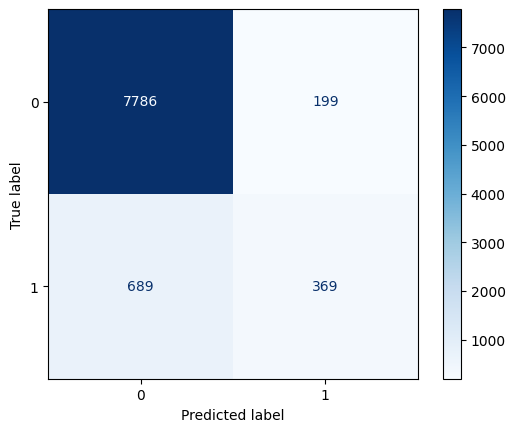

In [68]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

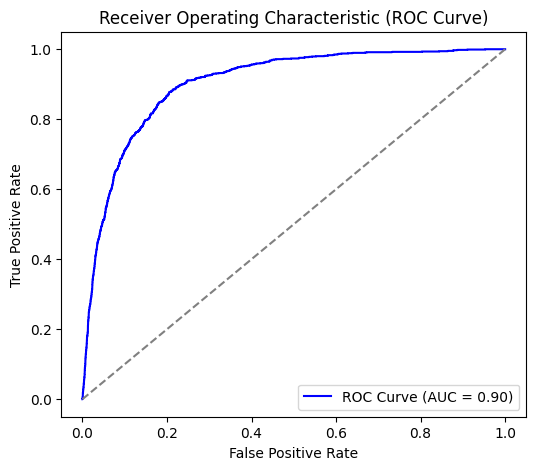

In [69]:
#ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC Curve)')
plt.legend()
plt.show()

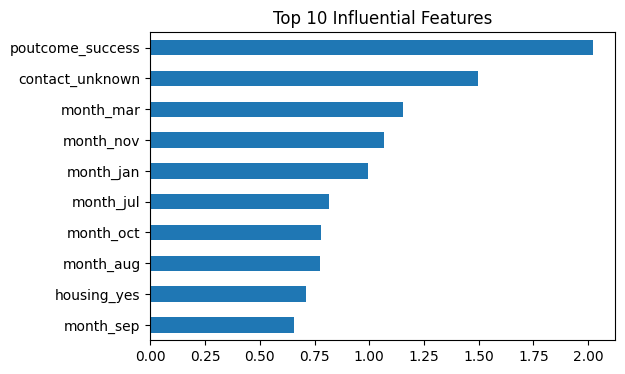

In [72]:
import numpy as np

coefficients = pd.Series(model.coef_[0], index=X_train.columns)
top_features = coefficients.abs().sort_values(ascending=False).head(10)
top_features.plot(kind='barh', figsize=(6, 4), title='Top 10 Influential Features')
plt.gca().invert_yaxis()
plt.show()

In [74]:
#Regression Rquation
coefficients = pd.Series(model.coef_[0], index=X_train.columns)
intercept = model.intercept_[0]
print("Intercept (β0):", intercept)
coefficients.head(10)

Intercept (β0): -0.887832704224782


,0
age,-0.017964
balance,0.000015
day,-0.000253
duration,0.004064
campaign,-0.104255
pdays,-0.001219
previous,0.001834
job_blue-collar,-0.290261
job_entrepreneur,-0.263741
job_housemaid,-0.417786
